# Detecção de fraude - cartão de crédito - Kaggle

## Introdução

Este notebook utiliza base de dados do Kaggle:
- https://www.kaggle.com/dalpozz/creditcardfraud

A base de dados contém mais de 284 mil transações de cartão de crédito contendo hora, valor e
28 atributos normalizados obtidos através de transformação PCA de redução de dimensionalidade.
Assim, ao todo são 30 atributos. O alvo do problema é prever se a transação é fraudulenta ou
genuína.
Uma característica fundamental deste dataset e que é comum em sistemas de fraudes é a diferença
entre respostas positivas: 284315 versus respostas negativas fraudulentas: 492. As fraudes 
representam apenas 0,17% das transações.
Este problema pode ser visto como sendo um problema de detecção de anomalia, entretanto iremos
tratá-la como um problema de classificação em duas classes utilizando redes neurais com
várias técnicas de regularização.

## Importação

In [101]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display
import os,sys
import time
import numpy as np
import pandas as pd
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
#import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR, StepLR
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable

#from torchvision import datasets, transforms, models

import sklearn.metrics

from lib.pytorch_utils import DeepNetTrainer

use_gpu = torch.cuda.is_available()
print('GPU available:', use_gpu)

GPU available: False


## Funções de apoio ao treinamento

In [2]:
class MyCallback(object):
    def __init__(self, interval=1):
        self.interval = interval
    
    def on_train_begin(self, trainer, has_validation=False):
        self.val = has_validation
        self.line_train = None
        self.line_valid = None
        
        self.fig = plt.figure(figsize=(15,6))
        self.ax = self.fig.add_subplot(1, 1, 1)
        self.ax.grid(True)
        self.plot_losses(trainer.metrics['train']['losses'], 
                         trainer.metrics['valid']['losses'])
    
    def on_epoch_end(self, trainer, epoch, best_epoch, t0):
        display.clear_output(wait=True)
        print('n epochs:', len(trainer.metrics['train']['losses']))
        for i in range(len(trainer.metrics['train']['losses'])):
            trainer.print_losses(i)
        if epoch % self.interval == 0:
            self.plot_losses(trainer.metrics['train']['losses'],
                             trainer.metrics['valid']['losses'], best_epoch==epoch)
        
    def plot_losses(self, htrain, hvalid, best_epoch=0):
        if self.line_train: self.line_train.remove()
        if self.line_valid: self.line_valid.remove()
        
        x = np.arange(1, len(htrain) + 1)
        self.line_train, = self.ax.plot(x, htrain, color='#1f77b4', linewidth=2, label='training loss')
        self.line_valid, = self.ax.plot(x, hvalid, color='#ff7f0e', linewidth=2, label='validation loss')
        self.ax.legend()
                
        if best_epoch:
            self.ax.vlines(best_epoch, *(self.ax.get_ylim()), colors='#EBDDE2', linestyles='dashed')

        display.display(self.fig)
        time.sleep(0.1)

    def plot_losses_2(self, htrain, hvalid, best_epoch=0):
        if self.line_train is None:
            line_train = plt.plot(htrain, linewidth=2, label='training loss')
            if hvalid[0]:
                line_valid = plt.plot(hvalid, linewidth=2, label='validation loss')
        else:
            self.line_train.set_xdata(np.arange(htrain.shape[0]))
            self.line_train.set_ydata(htrain)
            if hvalid[0]:
                self.line_valid.set_xdata(np.arange(hvalid.shape[0]))
                self.line_valid.set_ydata(hvalid)
                
        if best_epoch:
            plt.vlines(best_epoch, 0, 100, colors='#EBDDE2', linestyles='dashed')
            
        plt.legend()
        
        display.display(plt.gcf())
        display.clear_output(wait=True)

## Leitura dos dados

In [13]:
dataframe = pd.read_csv('/data/datasets/creditcard.csv', header=0)
print('dataframe.shape:',dataframe.shape)
dataframe.head()

dataframe.shape: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### converte rótulos para codificação one-hot e conta número de amostras em cada classe

In [9]:
target = np.asarray(dataframe['Class'])
n_samples = target.shape[0]
print('n. de amostras:', n_samples)
print('transações regulares:', (target==0).sum())
print('transações fraudulentas:', (target==1).sum())

n. de amostras: 284807
transações regulares: 284315
transações fraudulentas: 492


### Aplica mod no Timestamp para ser uma indicação da hora diária e normaliza dados 

In [7]:
df_cp = dataframe.copy()
inputs = np.asarray(df_cp.values)[:,:-1]
timestamp = inputs[:,0]
timestamp = timestamp % (60* 60 * 24) # modulo número de segundos por dia
inputs -= inputs.min(axis=0)
inputs /= inputs.max(axis=0)
inputs[:1],inputs.shape  # dados de uma amostra normalizada

(array([[ 0.        ,  0.93519234,  0.76649042,  0.8813649 ,  0.31302266,
          0.76343873,  0.26766864,  0.26681518,  0.7864442 ,  0.47531173,
          0.51060048,  0.25248432,  0.68090763,  0.3715906 ,  0.63559053,
          0.4460837 ,  0.43439239,  0.73717255,  0.65506586,  0.59486323,
          0.58294223,  0.56118439,  0.52299212,  0.66379298,  0.39125268,
          0.58512179,  0.39455679,  0.41897614,  0.31269663,  0.00582379]]),
 (284807, 30))

### Visualiza com boxplot

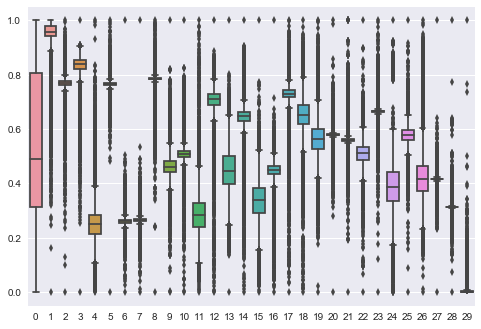

In [8]:
sns.boxplot(data=inputs[:,:])

In [ ]:
TensorDataset(inputs,target)

## Separação dados em treinamento e teste (20%)

In [15]:
i = np.random.randint(n_samples,size=(n_samples,))
split_index = int(0.8 * n_samples)
train_i = i[:split_index]
val_i   = i[split_index:]
x_train, y_train = inputs[train_i], target[train_i]
x_val,   y_val   = inputs[val_i],   target[val_i]

In [16]:
batch_size = 64
xt_train = torch.FloatTensor(x_train)
yt_train = torch.LongTensor(y_train)
train_data = TensorDataset(xt_train, yt_train)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

xt_val = torch.FloatTensor(x_val)
yt_val = torch.LongTensor(y_val)
val_data = TensorDataset(xt_val, yt_val)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

In [17]:
FEATURE_NUM = 30
CLASSES = 2
MAX_RANGE = 100

In [29]:
print(len(train_data),len(val_data))
n=0
for batch in train_loader:
    n = n + len(batch[0]) # comprimento de cada batch, 0 para pegar inputs
print(n)

227845 56962
227845


## Definição da rede

In [51]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.bn1   = nn.BatchNorm1d(FEATURE_NUM,)
        self.ln1   = nn.Linear(FEATURE_NUM,100)
        self.bn2   = nn.BatchNorm1d(100)
        self.ln2   = nn.Linear(100,100)
        self.ln3   = nn.Linear(100,50)
        self.ln4   = nn.Linear(50,CLASSES)

    def forward(self, x):
        x = self.bn1(x)           # (FEATURE_NUM,FEATURE_NUM)
        
        x = F.relu(self.ln1(x))   # (FEATURE_NUM,100)
        x = self.bn2(x)
        x = F.dropout(x,0.5)      # (100,100)
        
        x = F.relu(self.ln2(x))   # (100,100)
        x = F.dropout(x,0.5)
        
        x = F.relu(self.ln3(x))   # (100,50)
        x = F.dropout(x,0.5)
        
        x = self.ln4(x)           # (50,1)
        return x

model = Model()
if use_gpu:
    model.cuda()
model

Model (
  (bn1): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True)
  (ln1): Linear (30 -> 100)
  (bn2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True)
  (ln2): Linear (100 -> 100)
  (ln3): Linear (100 -> 50)
  (ln4): Linear (50 -> 2)
)

## Testando um predict

In [52]:
model(Variable(train_data[0:1][0]))

Variable containing:
 0.1456  0.0765
[torch.FloatTensor of size 1x2]

In [12]:
model = Sequential()
model.add(BatchNormalization(input_shape=(FEATURE_NUM,)))
model.add(GaussianNoise(0.4))
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(50))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(CLASSES, activation='softmax'))
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 30)                120       
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               3100      
_________________________________________________________________
activation_1 (Activation)    (None, 100)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
__________

## Treinamento

In [79]:
def compute_accuracy(logits, labels):
    _, preds = torch.max(logits.data, 1)
    return (torch.sum(preds == labels.data))/preds.size(0)

In [80]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = StepLR(optimizer, step_size=5, gamma=0.75)

trainer = DeepNetTrainer(
        file_basename = '../../models/creditcardfraud_pt',
        model =         model,
        criterion =     nn.CrossEntropyLoss(),
        metrics =       dict(acc=compute_accuracy),
        optimizer =     optimizer,
        lr_scheduler =  scheduler,
        callbacks =     [MyCallback()],
        reset =         True
        )

n epochs: 3
  0:   0.0s   T: 0.00253 0.99944   V: 0.59303 0.99835 best
  1:   0.0s   T: 0.00253 0.99944   V: 0.59303 0.99835 best
  2:   0.0s   T: 0.00253 0.99944   V: 0.59303 0.99835 best


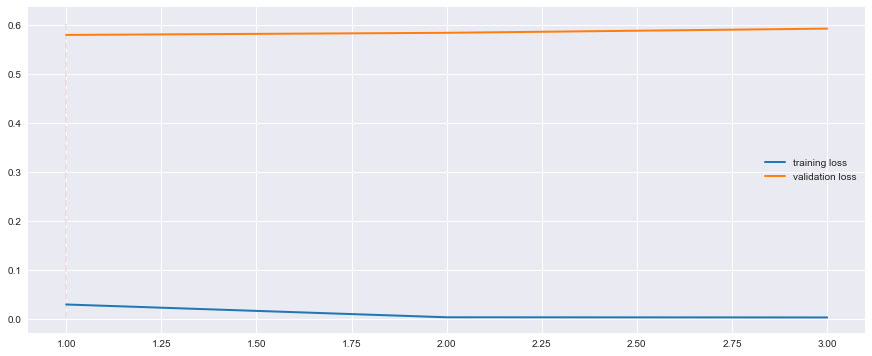


Model from epoch 1 saved as "../../models/creditcardfraud_pt.*", loss = 0.58011


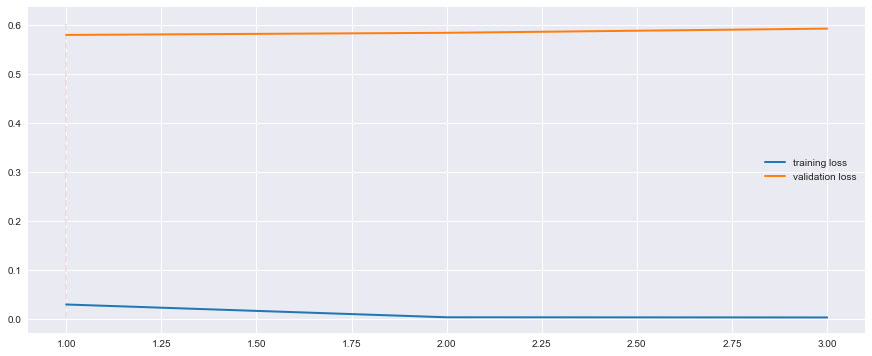

In [81]:
trainer.fit(3, train_loader, val_loader)


## Avaliação

In [83]:
metrics = trainer.evaluate(train_loader)
print('Model training set accuracy after training: {:.5f}'.format(metrics['acc']))
print()
metrics = trainer.evaluate(val_loader)
print('Model validation set accuracy after training: {:.5f}'.format(metrics['acc']))

evaluate: 3560 ok
Model training set accuracy after training: 0.99835

evaluate: 890 ok
Model validation set accuracy after training: 0.99835


In [99]:
output = trainer.predict(train_loader)
_, preds = torch.max(output, 1)
y_train_pred = preds.numpy()

predict: 3560 ok


In [102]:
print(sklearn.metrics.confusion_matrix(y_train,y_train_pred))
print(sklearn.metrics.classification_report(y_train,y_train_pred))

[[227470      0]
 [   375      0]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00    227470
          1       0.00      0.00      0.00       375

avg / total       1.00      1.00      1.00    227845



/Applications/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [103]:
output = trainer.predict(val_loader)
_, preds = torch.max(output, 1)
y_val_pred = preds.numpy()

predict: 890 ok


In [104]:
print(sklearn.metrics.confusion_matrix(y_val,y_pred))
print(sklearn.metrics.classification_report(y_val,y_pred))

[[56868     0]
 [   94     0]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     56868
          1       0.00      0.00      0.00        94

avg / total       1.00      1.00      1.00     56962



/Applications/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Aprendizados